In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Path to your dataset
train_dir = r'C:\Users\chiru c\Downloads\archive (10)\Data\train'
test_dir = r'C:\Users\chiru c\Downloads\archive (10)\Data\test'

# Data augmentation for training with 20% validation split
train_datagen = ImageDataGenerator(
    rescale=1./255,        # Normalize pixel values
    shear_range=0.2,       # Shearing
    zoom_range=0.2,        # Random zoom
    horizontal_flip=True,  # Horizontal flip
    validation_split=0.2   # Split 20% of the training data for validation
)

# Test data generator (no augmentation, only rescaling)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load the training data and validation data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),    # Resize all images to 224x224
    batch_size=32,             # Number of images to process in a batch
    class_mode='categorical',  # Since there are 3 classes: pneumonia, normal, COVID-19
    subset='training'          # Use the 'training' subset
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'        # Use the 'validation' subset
)

# Load the test data (no validation split here, just loading the test images)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',  # Categorical since we have 3 classes
    shuffle=False              # Do not shuffle for test data, keep the order
)



Found 4116 images belonging to 3 classes.
Found 1028 images belonging to 3 classes.
Found 1288 images belonging to 3 classes.


In [3]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

# Load the pre-trained ResNet50 model (excluding the top layers)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model's layers (optional - can unfreeze some layers for fine-tuning)
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers for your classification task (3 classes: pneumonia, normal, COVID-19)
x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)  # Add dropout to prevent overfitting
x = Dense(3, activation='softmax')(x)  # Output layer with 3 units for the 3 classes

# Create the model
model = Model(inputs=base_model.input, outputs=x)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


In [4]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // 32,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // 32,
    epochs=5  # Adjust the number of epochs as needed
)


Epoch 1/5


128/128 [==============================] - 422s 3s/step - loss: 0.9108 - accuracy: 0.6491 - val_loss: 0.7856 - val_accuracy: 0.6680
Epoch 2/5
128/128 [==============================] - 319s 2s/step - loss: 0.8192 - accuracy: 0.6746 - val_loss: 0.7328 - val_accuracy: 0.6787
Epoch 3/5
128/128 [==============================] - 359s 3s/step - loss: 0.7719 - accuracy: 0.6871 - val_loss: 0.6810 - val_accuracy: 0.6895
Epoch 4/5
128/128 [==============================] - 381s 3s/step - loss: 0.7494 - accuracy: 0.6983 - val_loss: 0.6926 - val_accuracy: 0.7354
Epoch 5/5
128/128 [==============================] - 428s 3s/step - loss: 0.7370 - accuracy: 0.7025 - val_loss: 0.6398 - val_accuracy: 0.7266


In [5]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")

41/41 [==============================] - 100s 2s/step - loss: 0.6000 - accuracy: 0.7686
Test Accuracy: 0.7686


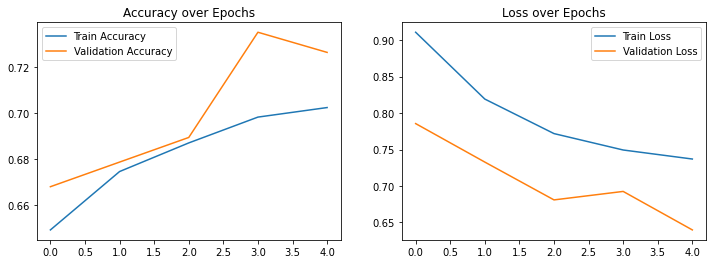

In [6]:
import matplotlib.pyplot as plt

# Plot accuracy and loss over epochs
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.show()

In [7]:
# Save the model to an H5 file
model.save('xray_classification_model.h5')

C:\Users\chiru c\anaconda3\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [8]:
# Load the saved model
from tensorflow.keras.models import load_model

loaded_model = load_model('xray_classification_model.h5')